In [2]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
class IssueDataset(Dataset):
    """
    Dataset for processing text data and multi-label classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # For multi-label classification, ensure we're passing the full label array
        # and not just a single value
        label = self.labels[idx]
        
        # Make sure we're getting a proper multi-dimensional label array
        # and not flattening it incorrectly
        if isinstance(label, (list, np.ndarray)):
            # Convert directly to tensor without modifying shape
            label = torch.tensor(label, dtype=torch.float)
        else:
            # If it's not already an array-like structure, this is likely a mistake
            # as we expect multi-label one-hot encoded data
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': label
        }

In [4]:
class CodeBERTClassifier(nn.Module):
    """
    A classifier model based on CodeBERT for multi-label classification.
    
    This model uses a pre-trained CodeBERT model as the encoder and adds a 
    classification head on top with sigmoid activation for multi-label output.
    
    Args:
        num_labels (int): Number of classes in the multi-label classification task.
    """
    def __init__(self, num_labels):
        super().__init__()
        self.codebert = RobertaModel.from_pretrained('microsoft/codebert-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        # Freeze all parameters in CodeBERT
        for param in self.codebert.parameters():
            param.requires_grad = False
        # Unfreeze pooler parameters for fine-tuning
        for param in self.codebert.pooler.parameters():
            param.requires_grad = True
        # Unfreeze parameters of the last 3 encoder layers
        for layer in self.codebert.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        # Return raw logits for BCEWithLogitsLoss (sigmoid will be applied in the loss function)
        return self.classifier(pooled_output)

In [5]:
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

In [1]:
def train_epoch(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch, computing loss and metrics for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        threshold (float): Threshold for binary predictions (default is 0.5).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, Hamming accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics for multi-label classification
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Use subset accuracy (exact match) for a strict measure
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False

In [6]:
def validate(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        device: Device to perform evaluation.
        threshold (float): Threshold for binary predictions (default is 0.5).

    Returns:
        tuple: Average loss, various accuracy metrics, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate different multi-label metrics
    
    # 1. Exact Match / Subset Accuracy (all labels must be correct)
    subset_accuracy = (all_preds == all_labels).all(axis=1).mean()
    
    # 2. Hamming Accuracy (fraction of correct labels)
    hamming_accuracy = (all_preds == all_labels).mean()
    
    # 3. Jaccard Similarity (intersection over union)
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        # Create a float array for output to avoid type casting error
        result = np.zeros_like(intersection, dtype=float)
        # Avoid division by zero
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    
    # Sample-based metrics - Each sample contributes equally regardless of number of labels
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": subset_accuracy, 
             "hamming": hamming_accuracy, 
             "jaccard": jaccard_sim}, 
            precision, recall, f1)


In [7]:
def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    
    Args:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted binary labels.
        class_names (list): Names of the classes/labels.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])  # Make it indexable for single class
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:  # Ensure we don't exceed the number of classes
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    return fig

In [8]:
def prepare_data(df, filter=True, min_label_freq=0, max_label_len=100, min_label_comb_freq=0):
    """
    Filter out infrequent labels and samples with too many labels.
    
    Args:
        df (pd.DataFrame): DataFrame with 'all_text' and 'labels'
        min_label_freq (int): Minimum frequency for a label to be considered frequent.
        max_label_len (int): Maximum number of labels per sample.
        min_label_comb_freq (int): Minimum frequency for a label combination to be kept.

    Returns:
        tuple: Filtered texts and labels.
    """
    # Only keep 'all_text' and 'labels' columns
    df = df[['all_text','labels']]
    # Filter out rows with 'nan' text
    df = df[~df['all_text'].apply(lambda x: x.startswith('nan'))]
    # Drop rows with missing labels
    df = df.dropna()
    
    # Extract issue texts and labels
    texts = df['all_text']  
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists

    if not filter:
        return texts, labels

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    print(f"Number of labels with at least {min_label_freq} occurrences: {len(frequent_labels)}")
    print(f"Removed {len(label_distribution) - len(frequent_labels)} infrequent labels")

    # Filter out infrequent labels
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    print(f"Number of samples after filtering: {len(filtered_labels)}")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    print(f"Number of label combinations with at least {min_label_comb_freq} occurrences: {len(frequent_combinations)}")
    print(f"Removed {len(label_combinations) - len(frequent_combinations)} infrequent label combinations")
    
    # Create mask for samples with frequent label combinations (if min_label_comb_freq > 0)
    if min_label_comb_freq > 0:
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        print(f"Number of samples with frequent label combinations: {comb_mask.sum()}")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"Final number of samples after all filtering: {len(filtered_labels)}")
    
    return texts, filtered_labels


# Train all data

Using device: cuda

 Label Distribution : 
0. area/test: 449
1. area/apiserver: 173
2. area/kubelet: 172
3. area/kubectl: 154
4. area/e2e-test-framework: 97
5. area/kubeadm: 92
6. area/code-generation: 80
7. area/cloudprovider: 72
8. area/dependency: 66
9. area/release-eng: 28
10. area/conformance: 26
11. area/provider/gcp: 18
12. area/kube-proxy: 17
13. area/provider/azure: 14
14. area/ipvs: 11
15. area/network-policy: 7
16. area/kubelet-api: 5
17. area/custom-resources: 5
18. area/admission-control: 5
19. area/stable-metrics: 5
20. area/ipv6: 4
21. area/provider/openstack: 3
22. area/logging: 3
23. area/hw-accelerators: 2
24. area/client-libraries: 2
25. area/code-organization: 2
26. area/etcd: 1
27. area/security: 1
28. area/test-infra: 1
29. area/batch: 1
30. area/workload-api/job: 1

 Label count per row distribution:
Label: 1, count: 508
Label: 2, count: 230
Label: 3, count: 61
Label: 4, count: 31
Label: 5, count: 12
Label: 6, count: 9
Label: 7, count: 8
Label: 8, count: 1
Label:

Training: 100%|██████████| 44/44 [00:39<00:00,  1.10it/s]


Train Loss: 0.6982, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.5905
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.8777
Val Accuracy (Jaccard): 0.1784
Val Precision: 0.2354, Val Recall: 0.4020, Val F1: 0.2729
Saved new best model

Epoch 2/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]


Train Loss: 0.5689, Train Accuracy (Exact Match): 0.0072
Val Loss: 0.5471
Val Accuracy (Exact Match): 0.0058
Val Accuracy (Hamming): 0.8986
Val Accuracy (Jaccard): 0.0446
Val Precision: 0.0665, Val Recall: 0.0707, Val F1: 0.0601

Epoch 3/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


Train Loss: 0.5293, Train Accuracy (Exact Match): 0.0029
Val Loss: 0.5369
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.8467
Val Accuracy (Jaccard): 0.0499
Val Precision: 0.0713, Val Recall: 0.1433, Val F1: 0.0824

Epoch 4/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


Train Loss: 0.5115, Train Accuracy (Exact Match): 0.0217
Val Loss: 0.5230
Val Accuracy (Exact Match): 0.0058
Val Accuracy (Hamming): 0.8917
Val Accuracy (Jaccard): 0.1992
Val Precision: 0.2417, Val Recall: 0.4311, Val F1: 0.2888
Saved new best model

Epoch 5/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


Train Loss: 0.4826, Train Accuracy (Exact Match): 0.0361
Val Loss: 0.4984
Val Accuracy (Exact Match): 0.0520
Val Accuracy (Hamming): 0.9114
Val Accuracy (Jaccard): 0.3225
Val Precision: 0.3951, Val Recall: 0.6398, Val F1: 0.4449
Saved new best model

Epoch 6/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


Train Loss: 0.4401, Train Accuracy (Exact Match): 0.1373
Val Loss: 0.4783
Val Accuracy (Exact Match): 0.1676
Val Accuracy (Hamming): 0.9334
Val Accuracy (Jaccard): 0.4477
Val Precision: 0.5497, Val Recall: 0.6769, Val F1: 0.5599
Saved new best model

Epoch 7/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


Train Loss: 0.4058, Train Accuracy (Exact Match): 0.2977
Val Loss: 0.4497
Val Accuracy (Exact Match): 0.1850
Val Accuracy (Hamming): 0.9304
Val Accuracy (Jaccard): 0.4679
Val Precision: 0.5665, Val Recall: 0.7221, Val F1: 0.5811
Saved new best model

Epoch 8/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


Train Loss: 0.3772, Train Accuracy (Exact Match): 0.3237
Val Loss: 0.4427
Val Accuracy (Exact Match): 0.3121
Val Accuracy (Hamming): 0.9411
Val Accuracy (Jaccard): 0.5454
Val Precision: 0.6673, Val Recall: 0.7105, Val F1: 0.6374
Saved new best model

Epoch 9/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


Train Loss: 0.3474, Train Accuracy (Exact Match): 0.3772
Val Loss: 0.4194
Val Accuracy (Exact Match): 0.3410
Val Accuracy (Hamming): 0.9487
Val Accuracy (Jaccard): 0.5724
Val Precision: 0.7136, Val Recall: 0.7091, Val F1: 0.6630
Saved new best model

Epoch 10/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


Train Loss: 0.3256, Train Accuracy (Exact Match): 0.4364
Val Loss: 0.4225
Val Accuracy (Exact Match): 0.3642
Val Accuracy (Hamming): 0.9526
Val Accuracy (Jaccard): 0.5951
Val Precision: 0.7413, Val Recall: 0.7002, Val F1: 0.6791
Saved new best model

Epoch 11/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


Train Loss: 0.3071, Train Accuracy (Exact Match): 0.4697
Val Loss: 0.4282
Val Accuracy (Exact Match): 0.3931
Val Accuracy (Hamming): 0.9556
Val Accuracy (Jaccard): 0.6042
Val Precision: 0.7471, Val Recall: 0.6992, Val F1: 0.6798
Saved new best model

Epoch 12/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


Train Loss: 0.2888, Train Accuracy (Exact Match): 0.4711
Val Loss: 0.4168
Val Accuracy (Exact Match): 0.3931
Val Accuracy (Hamming): 0.9515
Val Accuracy (Jaccard): 0.6065
Val Precision: 0.7485, Val Recall: 0.7161, Val F1: 0.6848
Saved new best model

Epoch 13/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


Train Loss: 0.2880, Train Accuracy (Exact Match): 0.4986
Val Loss: 0.4135
Val Accuracy (Exact Match): 0.3988
Val Accuracy (Hamming): 0.9530
Val Accuracy (Jaccard): 0.6113
Val Precision: 0.7609, Val Recall: 0.7076, Val F1: 0.6913
Saved new best model

Epoch 14/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


Train Loss: 0.2593, Train Accuracy (Exact Match): 0.4913
Val Loss: 0.4034
Val Accuracy (Exact Match): 0.3931
Val Accuracy (Hamming): 0.9526
Val Accuracy (Jaccard): 0.6133
Val Precision: 0.7466, Val Recall: 0.7360, Val F1: 0.6906

Epoch 15/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


Train Loss: 0.2415, Train Accuracy (Exact Match): 0.5000
Val Loss: 0.4162
Val Accuracy (Exact Match): 0.4220
Val Accuracy (Hamming): 0.9547
Val Accuracy (Jaccard): 0.6302
Val Precision: 0.7748, Val Recall: 0.7163, Val F1: 0.7062
Saved new best model

Epoch 16/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


Train Loss: 0.2288, Train Accuracy (Exact Match): 0.5188
Val Loss: 0.4152
Val Accuracy (Exact Match): 0.4220
Val Accuracy (Hamming): 0.9554
Val Accuracy (Jaccard): 0.6257
Val Precision: 0.7803, Val Recall: 0.7095, Val F1: 0.6979

Epoch 17/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


Train Loss: 0.2147, Train Accuracy (Exact Match): 0.5260
Val Loss: 0.4094
Val Accuracy (Exact Match): 0.4277
Val Accuracy (Hamming): 0.9552
Val Accuracy (Jaccard): 0.6314
Val Precision: 0.7657, Val Recall: 0.7375, Val F1: 0.7052

Epoch 18/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


Train Loss: 0.2042, Train Accuracy (Exact Match): 0.5332
Val Loss: 0.4091
Val Accuracy (Exact Match): 0.4393
Val Accuracy (Hamming): 0.9560
Val Accuracy (Jaccard): 0.6489
Val Precision: 0.7860, Val Recall: 0.7613, Val F1: 0.7266
Saved new best model

Epoch 19/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.13it/s]


Train Loss: 0.1929, Train Accuracy (Exact Match): 0.5506
Val Loss: 0.4121
Val Accuracy (Exact Match): 0.4104
Val Accuracy (Hamming): 0.9566
Val Accuracy (Jaccard): 0.6354
Val Precision: 0.7848, Val Recall: 0.7404, Val F1: 0.7154

Epoch 20/20


Training: 100%|██████████| 44/44 [00:38<00:00,  1.14it/s]


Train Loss: 0.1851, Train Accuracy (Exact Match): 0.5838
Val Loss: 0.4150
Val Accuracy (Exact Match): 0.4335
Val Accuracy (Hamming): 0.9582
Val Accuracy (Jaccard): 0.6448
Val Precision: 0.7892, Val Recall: 0.7495, Val F1: 0.7218

Loading best model for final evaluation...


<ipython-input-17-e924e00141c3>:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_codebert_multilabel_model.pt'))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4393
Hamming Accuracy: 0.9560
Jaccard Similarity: 0.6489
Precision: 0.7860
Recall: 0.7613
F1 Score: 0.7266


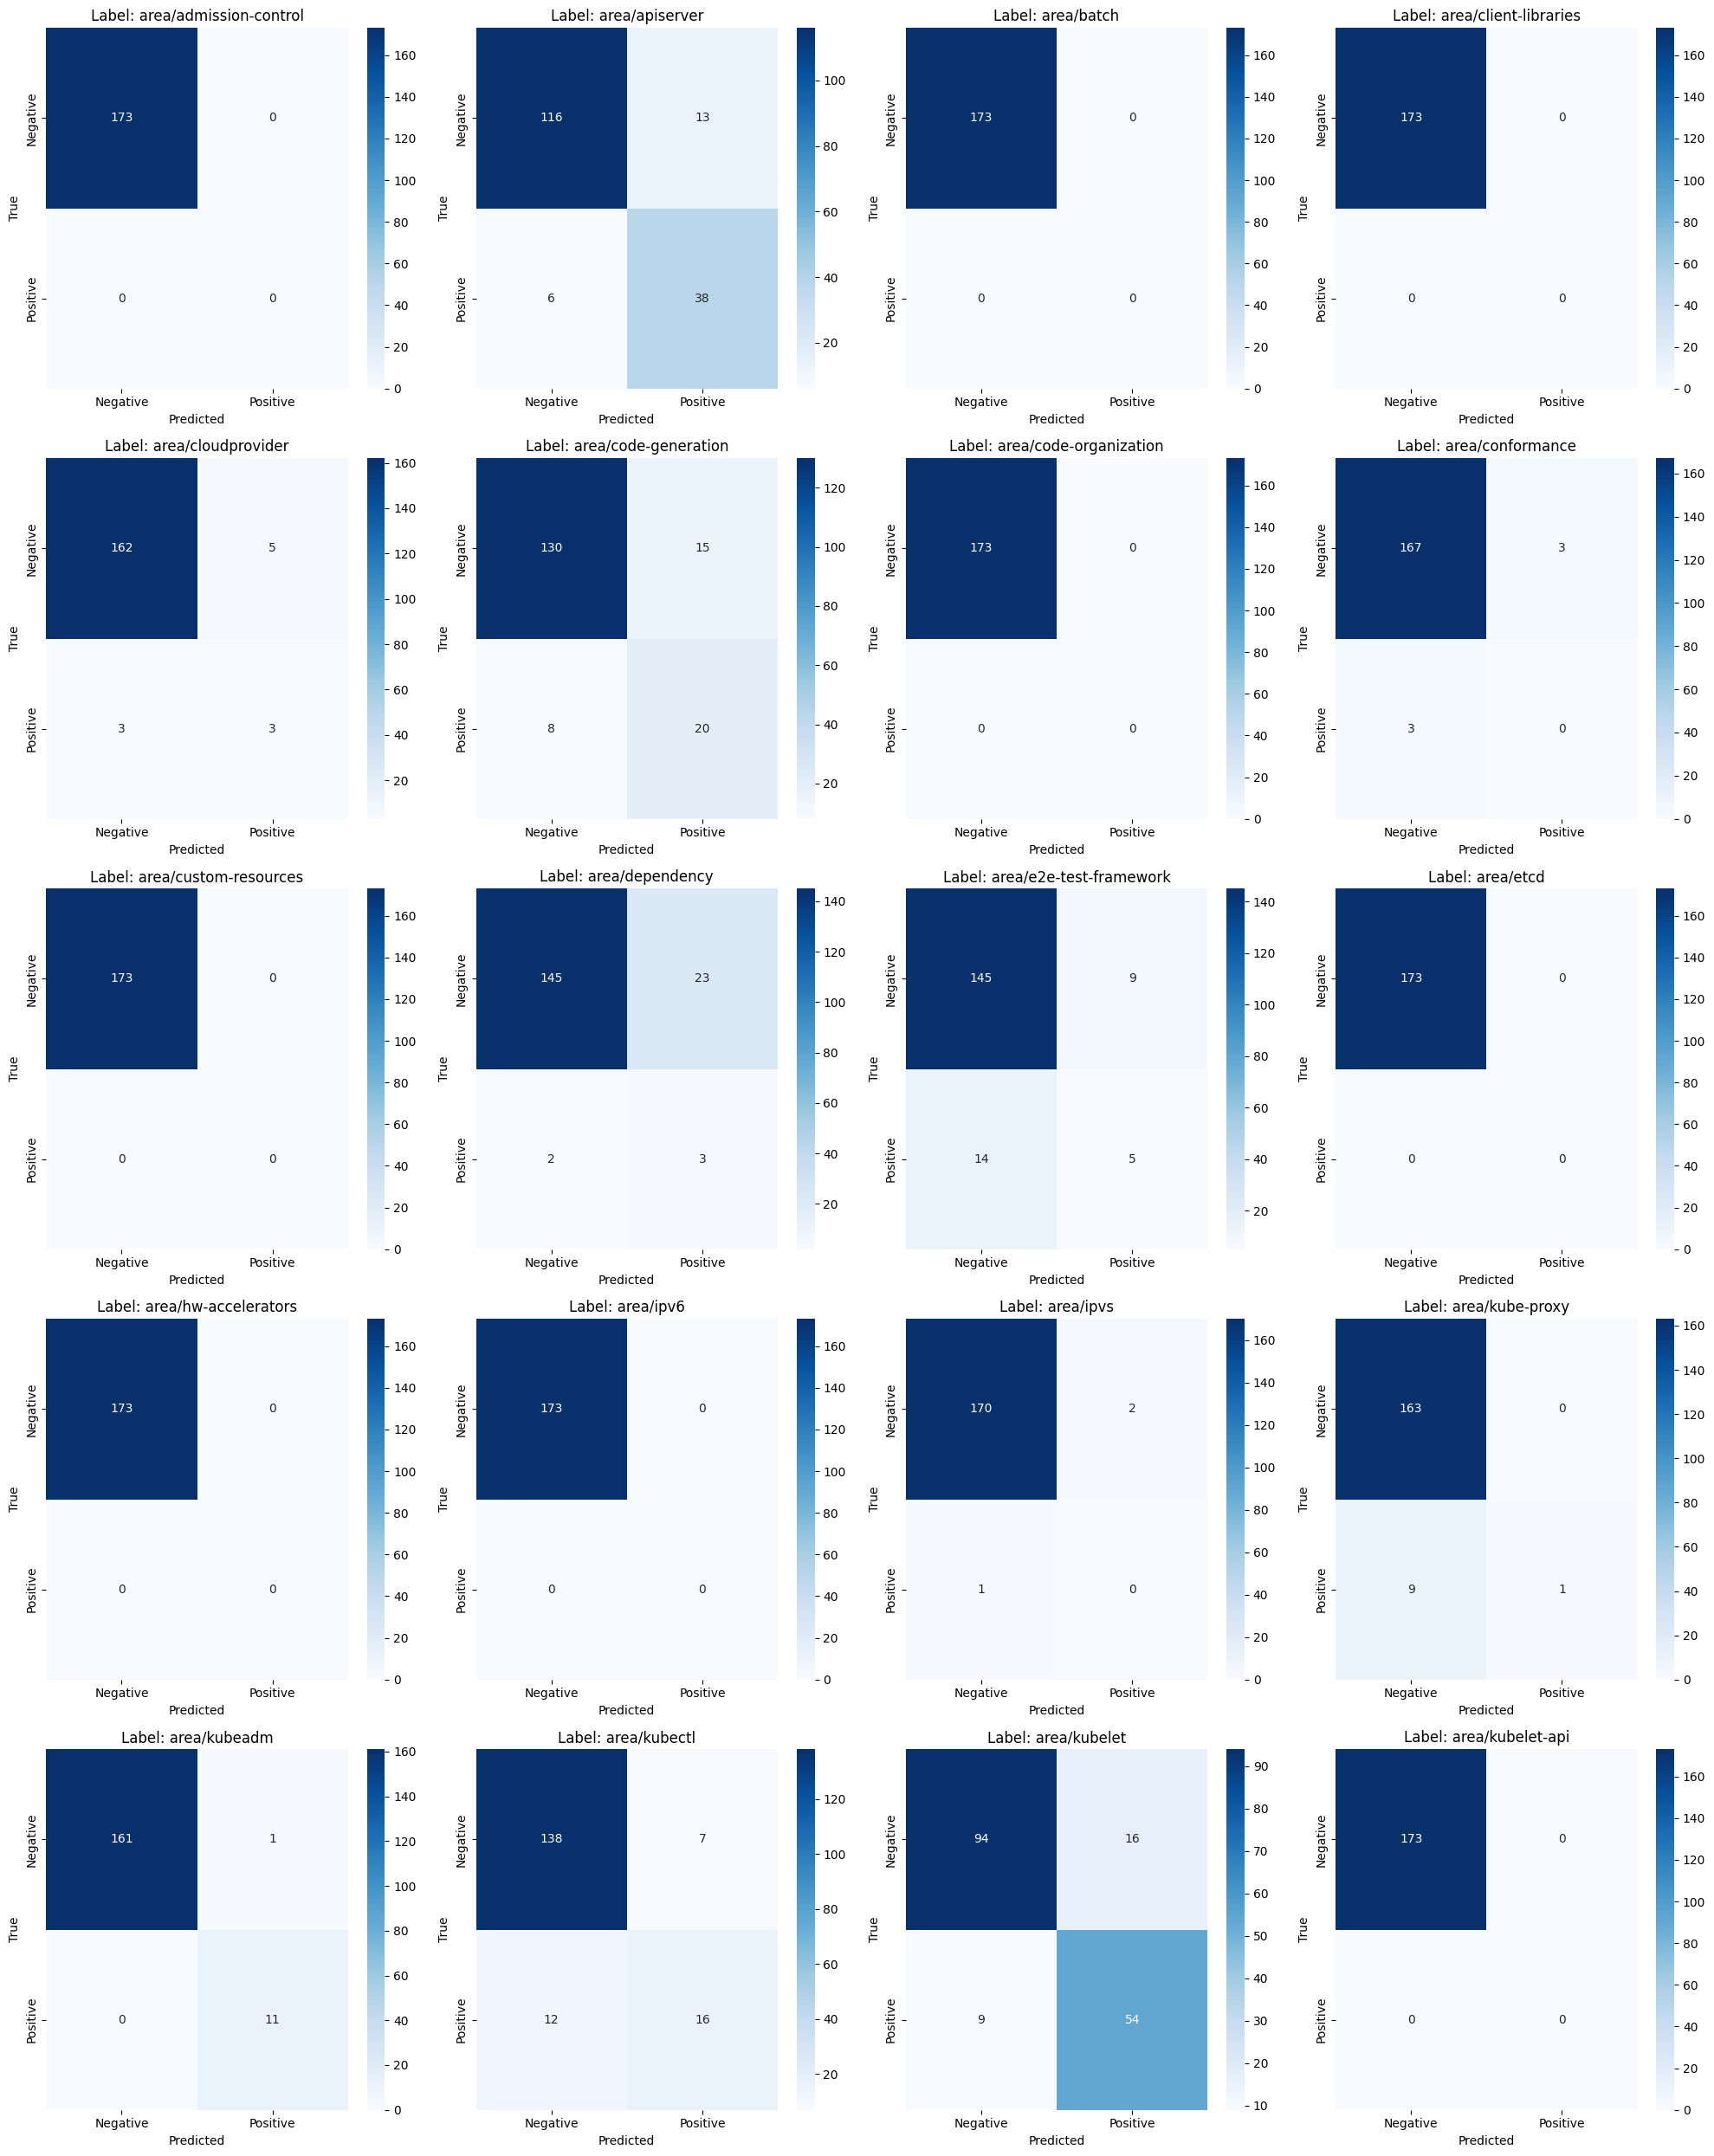

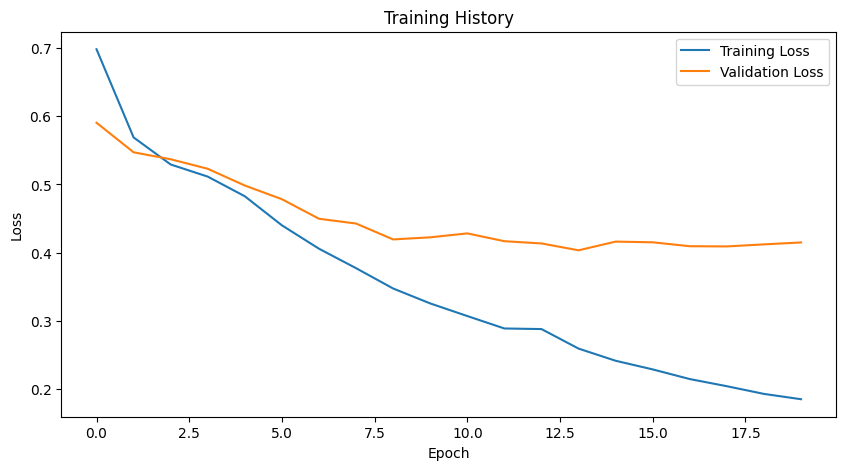


Training completed!


In [17]:
def main():
    """
    Main function to run the multi-label classification pipeline with CodeBERT.
    This function loads data, preprocesses it, trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load data
    data_path = "/kaggle/input/kubernetes-cleaned-data-with-changed-file-info/cleaned_data_with_changed_files.json"
    df = pd.read_json(data_path)
    
    # Use prepare_data function to filter and prepare data
    texts, filtered_labels = prepare_data(df, filter=False)
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\n Label Distribution : ')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\n Label count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')

    # Count the distribution of label combinations
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    print('\n Label combinations distribution:')
    for i, (labels, count) in enumerate(sorted(label_combinations.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. Label combination: {labels}, count: {count}')
    
    # Encode multi-labels using MultiLabelBinarizer
    print("\n Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Calculate  label distribution
    label_counts = labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (labels_encoded.shape[0] * labels_encoded.shape[1])
    print(f"Label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / labels_encoded.shape[0]:.2f}")
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = 16
    train_dataset = IssueDataset(train_texts, train_labels, tokenizer)
    val_dataset = IssueDataset(val_texts, val_labels, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    model = CodeBERTClassifier(num_labels=len(mlb.classes_)).to(device)
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=3, min_delta=0.01)
    
    # Training loop
    num_epochs = 20
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Hamming): {accuracy_metrics['hamming']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_codebert_multilabel_model.pt')
            print("Saved new best model")
        
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    model.load_state_dict(torch.load('best_codebert_multilabel_model.pt'))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Hamming Accuracy: {final_acc_metrics['hamming']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()
    
    print("\nTraining completed!")
    
    return {
        'metrics': {
            'exact_match': final_acc_metrics['exact_match'],
            'hamming': final_acc_metrics['hamming'],
            'jaccard': final_acc_metrics['jaccard'],
            'precision': final_precision,
            'recall': final_recall, 
            'f1': final_f1,
        },
        'model': model,
        'label_encoder': mlb
    }
    
if __name__ == "__main__":
    results = main()

# Filter labels that have > 5 data

Using device: cuda
Number of labels with at least 5 occurrences: 20
Removed 11 infrequent labels
Number of samples after filtering: 865
Number of label combinations with at least 0 occurrences: 118
Removed 0 infrequent label combinations
Final number of samples after all filtering: 848

 Label Distribution : 
0. area/test: 445
1. area/apiserver: 171
2. area/kubelet: 169
3. area/kubectl: 153
4. area/e2e-test-framework: 97
5. area/kubeadm: 92
6. area/code-generation: 77
7. area/cloudprovider: 70
8. area/dependency: 65
9. area/release-eng: 28
10. area/conformance: 26
11. area/provider/gcp: 18
12. area/kube-proxy: 16
13. area/provider/azure: 14
14. area/ipvs: 11
15. area/network-policy: 7
16. area/kubelet-api: 5
17. area/custom-resources: 5
18. area/admission-control: 5
19. area/stable-metrics: 5

 Label count per row distribution:
Label: 1, count: 500
Label: 2, count: 227
Label: 3, count: 57
Label: 4, count: 30
Label: 5, count: 12
Label: 6, count: 9
Label: 7, count: 7
Label: 8, count: 1
L

Training: 100%|██████████| 43/43 [00:38<00:00,  1.10it/s]


Train Loss: 0.8108, Train Accuracy (Exact Match): 0.0000
Val Loss: 0.7707
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.7429
Val Accuracy (Jaccard): 0.1593
Val Precision: 0.1889, Val Recall: 0.5367, Val F1: 0.2581
Saved new best model

Epoch 2/20


Training: 100%|██████████| 43/43 [00:37<00:00,  1.15it/s]


Train Loss: 0.7428, Train Accuracy (Exact Match): 0.0029
Val Loss: 0.7617
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.7412
Val Accuracy (Jaccard): 0.0734
Val Precision: 0.0957, Val Recall: 0.2235, Val F1: 0.1206

Epoch 3/20


Training: 100%|██████████| 43/43 [00:38<00:00,  1.13it/s]


Train Loss: 0.7186, Train Accuracy (Exact Match): 0.0118
Val Loss: 0.7661
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.7718
Val Accuracy (Jaccard): 0.1489
Val Precision: 0.1755, Val Recall: 0.4710, Val F1: 0.2360

Epoch 4/20


Training: 100%|██████████| 43/43 [00:37<00:00,  1.14it/s]


Train Loss: 0.6731, Train Accuracy (Exact Match): 0.0457
Val Loss: 0.7119
Val Accuracy (Exact Match): 0.0765
Val Accuracy (Hamming): 0.8706
Val Accuracy (Jaccard): 0.3120
Val Precision: 0.3907, Val Recall: 0.5540, Val F1: 0.4150
Saved new best model

Epoch 5/20


Training: 100%|██████████| 43/43 [00:37<00:00,  1.13it/s]


Train Loss: 0.6102, Train Accuracy (Exact Match): 0.1814
Val Loss: 0.6818
Val Accuracy (Exact Match): 0.0941
Val Accuracy (Hamming): 0.8621
Val Accuracy (Jaccard): 0.3581
Val Precision: 0.4408, Val Recall: 0.6432, Val F1: 0.4717
Saved new best model

Epoch 6/20


Training: 100%|██████████| 43/43 [00:38<00:00,  1.13it/s]


Train Loss: 0.5605, Train Accuracy (Exact Match): 0.2139
Val Loss: 0.6415
Val Accuracy (Exact Match): 0.1294
Val Accuracy (Hamming): 0.8906
Val Accuracy (Jaccard): 0.4353
Val Precision: 0.5167, Val Recall: 0.7082, Val F1: 0.5521
Saved new best model

Epoch 7/20


Training: 100%|██████████| 43/43 [00:37<00:00,  1.13it/s]


Train Loss: 0.5123, Train Accuracy (Exact Match): 0.2817
Val Loss: 0.6216
Val Accuracy (Exact Match): 0.2647
Val Accuracy (Hamming): 0.9068
Val Accuracy (Jaccard): 0.5059
Val Precision: 0.6073, Val Recall: 0.6975, Val F1: 0.6014
Saved new best model

Epoch 8/20


Training: 100%|██████████| 43/43 [00:38<00:00,  1.13it/s]


Train Loss: 0.4698, Train Accuracy (Exact Match): 0.3614
Val Loss: 0.6029
Val Accuracy (Exact Match): 0.3000
Val Accuracy (Hamming): 0.9144
Val Accuracy (Jaccard): 0.5476
Val Precision: 0.6557, Val Recall: 0.7266, Val F1: 0.6397
Saved new best model

Epoch 9/20


Training: 100%|██████████| 43/43 [00:38<00:00,  1.13it/s]


Train Loss: 0.4351, Train Accuracy (Exact Match): 0.4159
Val Loss: 0.5845
Val Accuracy (Exact Match): 0.3412
Val Accuracy (Hamming): 0.9162
Val Accuracy (Jaccard): 0.5601
Val Precision: 0.6995, Val Recall: 0.6916, Val F1: 0.6474
Saved new best model

Epoch 10/20


Training: 100%|██████████| 43/43 [00:38<00:00,  1.13it/s]


Train Loss: 0.4071, Train Accuracy (Exact Match): 0.4336
Val Loss: 0.5918
Val Accuracy (Exact Match): 0.4235
Val Accuracy (Hamming): 0.9312
Val Accuracy (Jaccard): 0.6265
Val Precision: 0.7457, Val Recall: 0.7436, Val F1: 0.7010
Saved new best model

Epoch 11/20


Training: 100%|██████████| 43/43 [00:37<00:00,  1.13it/s]


Train Loss: 0.3713, Train Accuracy (Exact Match): 0.4808
Val Loss: 0.5890
Val Accuracy (Exact Match): 0.4118
Val Accuracy (Hamming): 0.9344
Val Accuracy (Jaccard): 0.6264
Val Precision: 0.7600, Val Recall: 0.7236, Val F1: 0.7000

Epoch 12/20


Training: 100%|██████████| 43/43 [00:37<00:00,  1.13it/s]


Train Loss: 0.3495, Train Accuracy (Exact Match): 0.5044
Val Loss: 0.5853
Val Accuracy (Exact Match): 0.4000
Val Accuracy (Hamming): 0.9282
Val Accuracy (Jaccard): 0.6156
Val Precision: 0.7438, Val Recall: 0.7346, Val F1: 0.6927

Epoch 13/20


Training: 100%|██████████| 43/43 [00:38<00:00,  1.13it/s]


Train Loss: 0.2903, Train Accuracy (Exact Match): 0.5442
Val Loss: 0.5866
Val Accuracy (Exact Match): 0.3706
Val Accuracy (Hamming): 0.9265
Val Accuracy (Jaccard): 0.6013
Val Precision: 0.7305, Val Recall: 0.7406, Val F1: 0.6823

Epoch 16/20


Training: 100%|██████████| 43/43 [00:38<00:00,  1.13it/s]


Train Loss: 0.2687, Train Accuracy (Exact Match): 0.5339
Val Loss: 0.6190
Val Accuracy (Exact Match): 0.4529
Val Accuracy (Hamming): 0.9341
Val Accuracy (Jaccard): 0.6343
Val Precision: 0.7701, Val Recall: 0.7135, Val F1: 0.7005

Epoch 17/20


Training: 100%|██████████| 43/43 [00:37<00:00,  1.13it/s]


Train Loss: 0.2576, Train Accuracy (Exact Match): 0.5782
Val Loss: 0.5704
Val Accuracy (Exact Match): 0.3529
Val Accuracy (Hamming): 0.9144
Val Accuracy (Jaccard): 0.5831
Val Precision: 0.7061, Val Recall: 0.7478, Val F1: 0.6697

Epoch 18/20


Training: 100%|██████████| 43/43 [00:37<00:00,  1.13it/s]


Train Loss: 0.2445, Train Accuracy (Exact Match): 0.5619
Val Loss: 0.5981
Val Accuracy (Exact Match): 0.4235
Val Accuracy (Hamming): 0.9338
Val Accuracy (Jaccard): 0.6365
Val Precision: 0.7768, Val Recall: 0.7434, Val F1: 0.7124
Saved new best model

Epoch 19/20


Training: 100%|██████████| 43/43 [00:37<00:00,  1.13it/s]


Train Loss: 0.2230, Train Accuracy (Exact Match): 0.5708
Val Loss: 0.6149
Val Accuracy (Exact Match): 0.4118
Val Accuracy (Hamming): 0.9329
Val Accuracy (Jaccard): 0.6249
Val Precision: 0.7660, Val Recall: 0.7362, Val F1: 0.7023

Epoch 20/20


Training: 100%|██████████| 43/43 [00:37<00:00,  1.13it/s]


Train Loss: 0.2180, Train Accuracy (Exact Match): 0.5959
Val Loss: 0.6222
Val Accuracy (Exact Match): 0.4059
Val Accuracy (Hamming): 0.9285
Val Accuracy (Jaccard): 0.6222
Val Precision: 0.7595, Val Recall: 0.7399, Val F1: 0.7002

Loading best model for final evaluation...


<ipython-input-16-0c2a57f9f96f>:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_codebert_multilabel_model.pt'))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4235
Hamming Accuracy: 0.9338
Jaccard Similarity: 0.6365
Precision: 0.7768
Recall: 0.7434
F1 Score: 0.7124


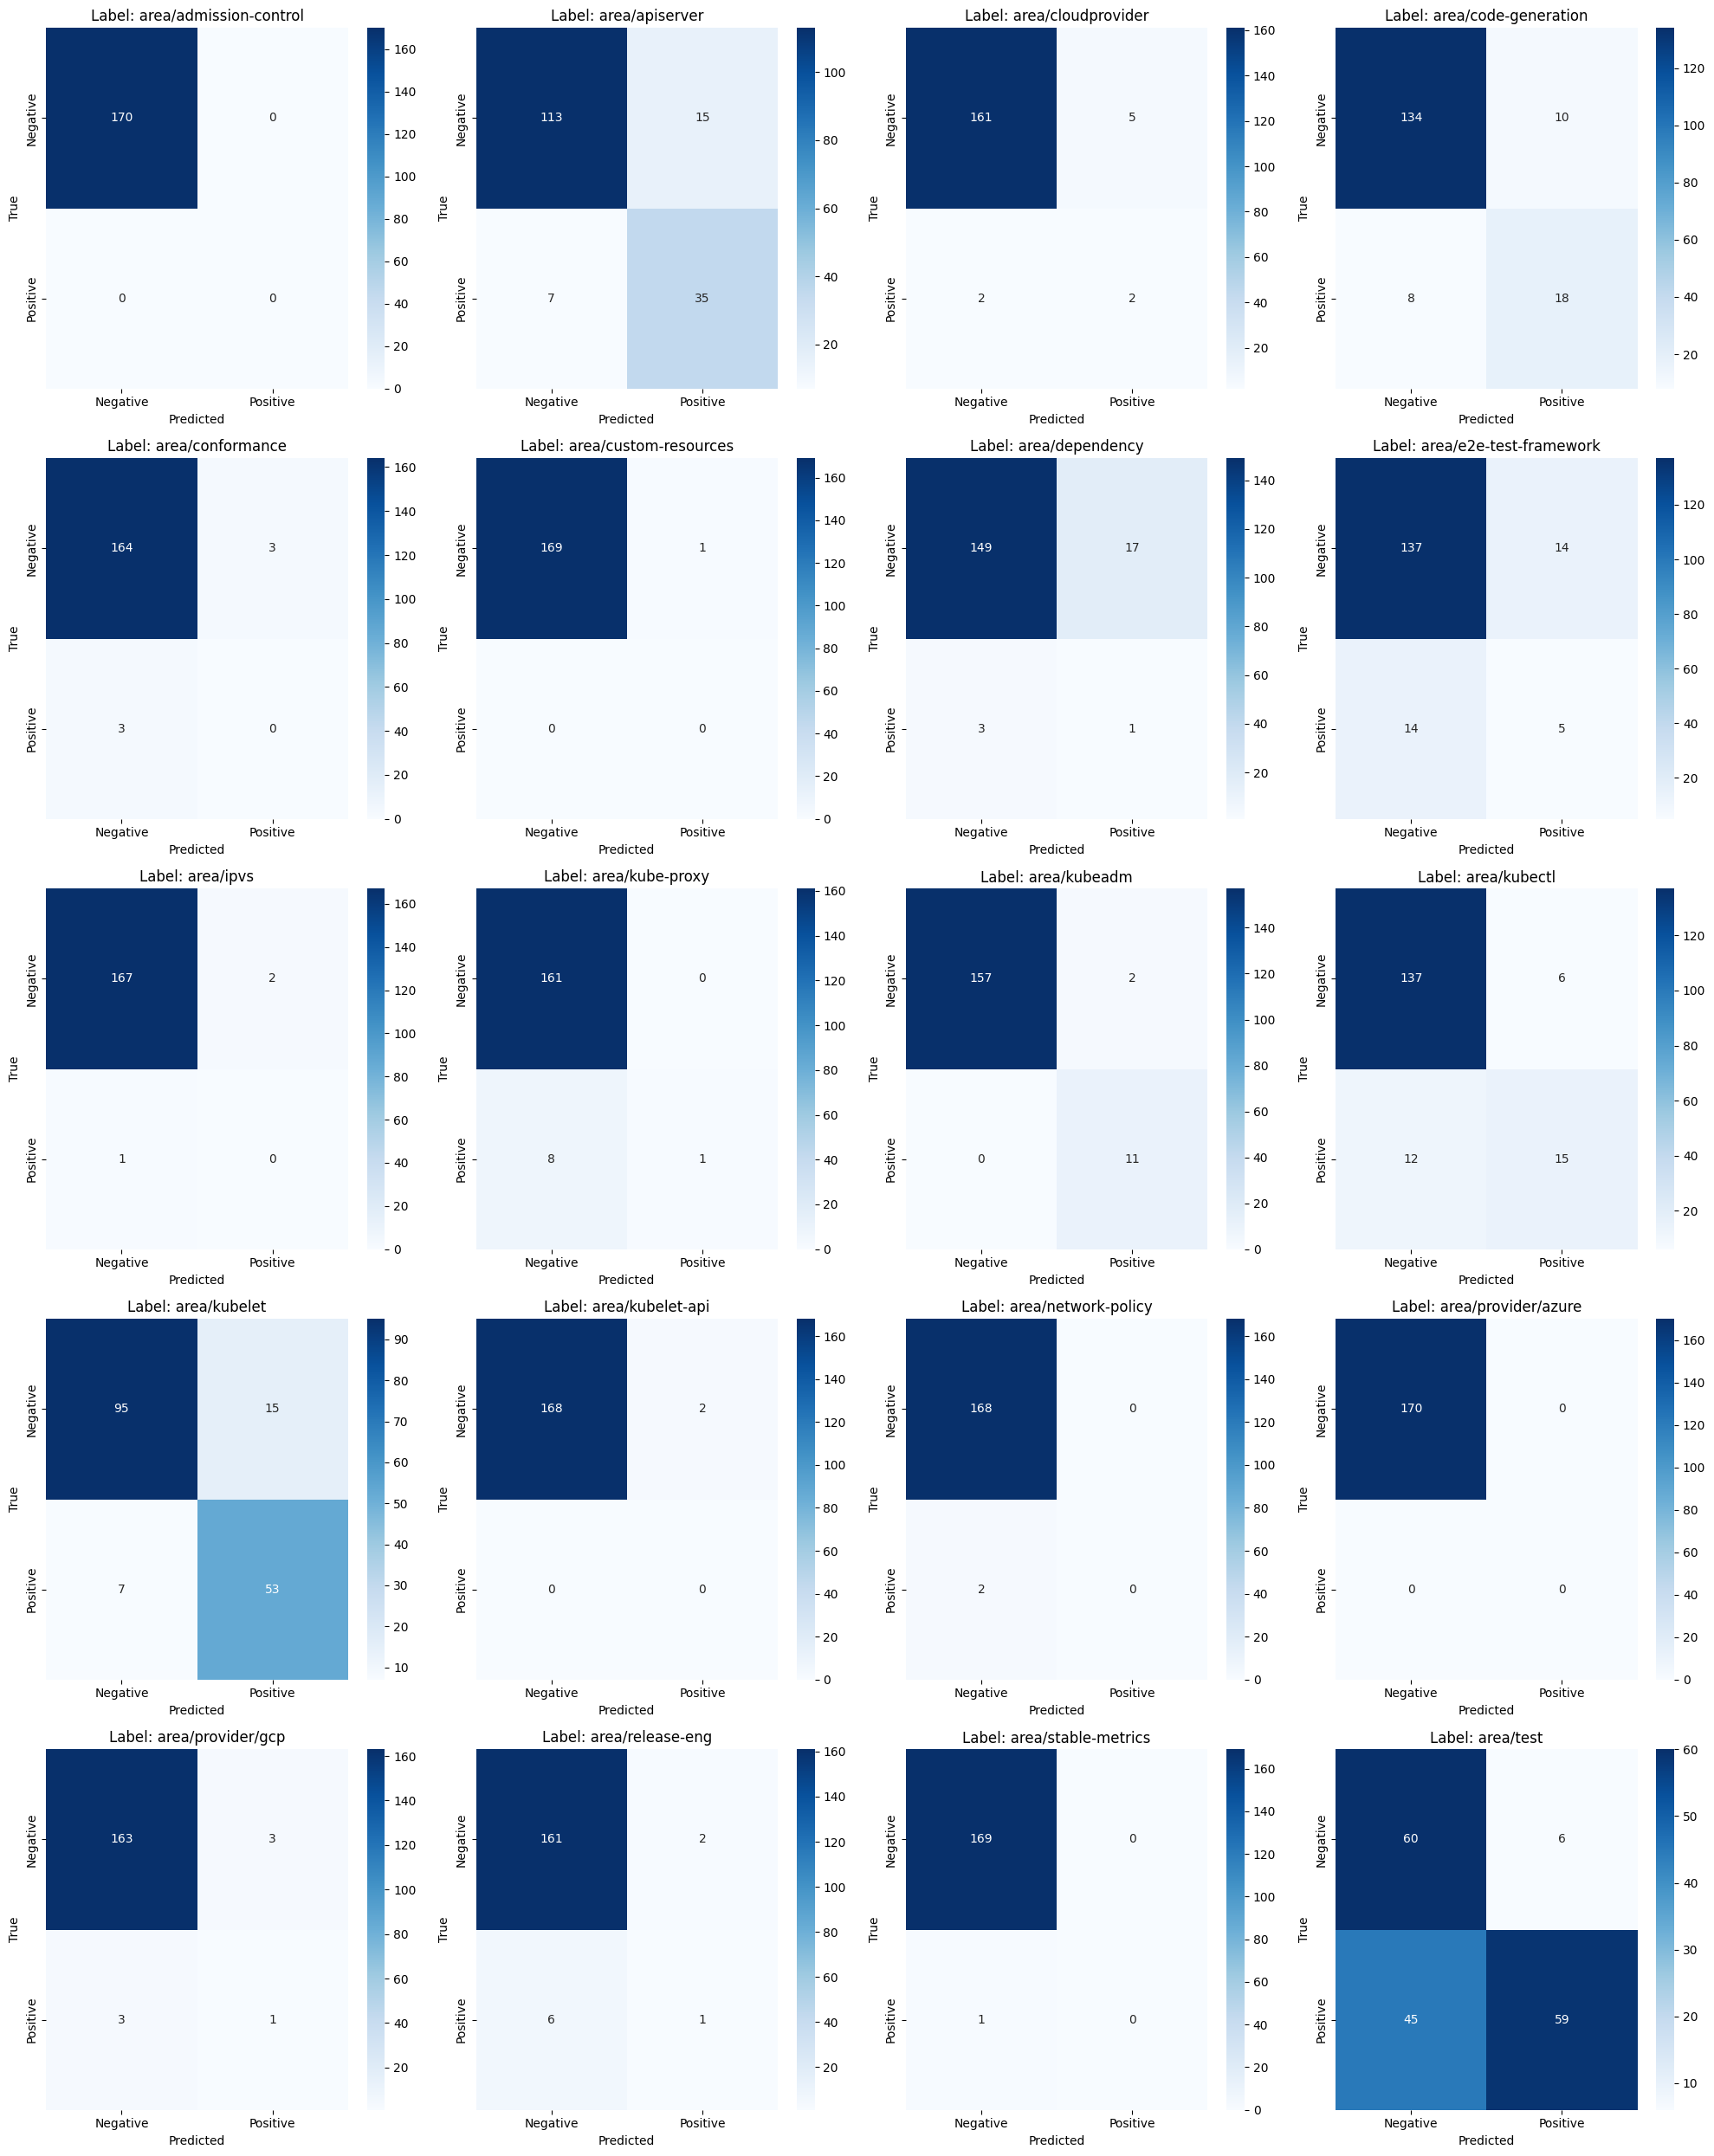

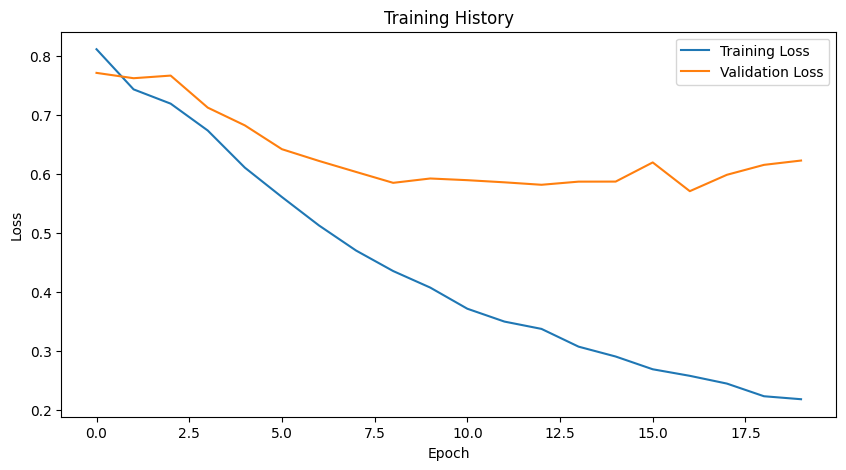


Training completed!


In [16]:
def main():
    """
    Main function to run the multi-label classification pipeline with CodeBERT.
    This function loads data, preprocesses it, trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load data
    data_path = "/kaggle/input/kubernetes-cleaned-data-with-changed-file-info/cleaned_data_with_changed_files.json"
    df = pd.read_json(data_path)
    
    # Use prepare_data function to filter and prepare data
    texts, filtered_labels = prepare_data(df, min_label_freq=5)
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\n Label Distribution : ')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\n Label count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')

    # Count the distribution of label combinations
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    print('\n Label combinations distribution:')
    for i, (labels, count) in enumerate(sorted(label_combinations.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. Label combination: {labels}, count: {count}')
    
    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Calculate  label distribution
    label_counts = labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (labels_encoded.shape[0] * labels_encoded.shape[1])
    print(f"Label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / labels_encoded.shape[0]:.2f}")
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = 16
    train_dataset = IssueDataset(train_texts, train_labels, tokenizer)
    val_dataset = IssueDataset(val_texts, val_labels, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    model = CodeBERTClassifier(num_labels=len(mlb.classes_)).to(device)
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=3, min_delta=0.01)
    
    # Training loop
    num_epochs = 20
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Hamming): {accuracy_metrics['hamming']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_codebert_multilabel_model.pt')
            print("Saved new best model")
        
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    model.load_state_dict(torch.load('best_codebert_multilabel_model.pt'))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Hamming Accuracy: {final_acc_metrics['hamming']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()
    
    print("\nTraining completed!")
    
    return {
        'metrics': {
            'exact_match': final_acc_metrics['exact_match'],
            'hamming': final_acc_metrics['hamming'],
            'jaccard': final_acc_metrics['jaccard'],
            'precision': final_precision,
            'recall': final_recall, 
            'f1': final_f1,
        },
        'model': model,
        'label_encoder': mlb
    }
    
if __name__ == "__main__":
    results = main()

# Keep data that have <= 5 labels & min 5 data per label

Using device: cuda
Loading data...

Total number of unique labels: 31
Number of labels with at least 5 occurrences: 20
Label frequency distribution saved as 'label_frequency_distribution.png'
Filtered label length distribution saved as 'filtered_label_length_distribution.png'

Label length distribution after filtering:
  1 labels: 501 samples (60.00%)
  2 labels: 230 samples (27.54%)
  3 labels: 60 samples (7.19%)
  4 labels: 32 samples (3.83%)
  5 labels: 12 samples (1.44%)
Encoding labels...
Number of unique labels after filtering: 20
Example of encoded labels shape: (835, 20)
Label distribution (top 10):
  area/admission-control: 5 occurrences
  area/apiserver: 156 occurrences
  area/cloudprovider: 52 occurrences
  area/code-generation: 61 occurrences
  area/conformance: 21 occurrences
  area/custom-resources: 5 occurrences
  area/dependency: 51 occurrences
  area/e2e-test-framework: 86 occurrences
  area/ipvs: 9 occurrences
  area/kube-proxy: 13 occurrences
Label density: 0.0796
Av

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Using weighted BCE loss
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 42/42 [00:20<00:00,  2.04it/s]


Train Loss: 0.7895, Train Accuracy (Exact Match): 0.0030
Val Loss: 0.6941
Val Accuracy (Exact Match): 0.0120
Val Accuracy (Hamming): 0.8533
Val Accuracy (Jaccard): 0.2272
Val Precision: 0.2970, Val Recall: 0.4302, Val F1: 0.3243
Saved new best model

Epoch 2/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]


Train Loss: 0.7106, Train Accuracy (Exact Match): 0.0584
Val Loss: 0.6912
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.7973
Val Accuracy (Jaccard): 0.1232
Val Precision: 0.1414, Val Recall: 0.3358, Val F1: 0.1896

Epoch 3/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.14it/s]


Train Loss: 0.6775, Train Accuracy (Exact Match): 0.0299
Val Loss: 0.6578
Val Accuracy (Exact Match): 0.0120
Val Accuracy (Hamming): 0.8249
Val Accuracy (Jaccard): 0.1096
Val Precision: 0.1312, Val Recall: 0.2351, Val F1: 0.1590

Epoch 4/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]


Train Loss: 0.6193, Train Accuracy (Exact Match): 0.0943
Val Loss: 0.6116
Val Accuracy (Exact Match): 0.1078
Val Accuracy (Hamming): 0.8934
Val Accuracy (Jaccard): 0.3456
Val Precision: 0.4306, Val Recall: 0.5687, Val F1: 0.4499
Saved new best model

Epoch 5/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


Train Loss: 0.5560, Train Accuracy (Exact Match): 0.2231
Val Loss: 0.5840
Val Accuracy (Exact Match): 0.1317
Val Accuracy (Hamming): 0.8859
Val Accuracy (Jaccard): 0.3880
Val Precision: 0.4649, Val Recall: 0.6301, Val F1: 0.4961
Saved new best model

Epoch 6/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


Train Loss: 0.5039, Train Accuracy (Exact Match): 0.2275
Val Loss: 0.5280
Val Accuracy (Exact Match): 0.1497
Val Accuracy (Hamming): 0.9006
Val Accuracy (Jaccard): 0.4449
Val Precision: 0.5352, Val Recall: 0.6878, Val F1: 0.5550
Saved new best model

Epoch 7/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


Train Loss: 0.4532, Train Accuracy (Exact Match): 0.3353
Val Loss: 0.4936
Val Accuracy (Exact Match): 0.2814
Val Accuracy (Hamming): 0.9195
Val Accuracy (Jaccard): 0.5394
Val Precision: 0.6354, Val Recall: 0.7357, Val F1: 0.6354
Saved new best model

Epoch 8/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


Train Loss: 0.4088, Train Accuracy (Exact Match): 0.4207
Val Loss: 0.4673
Val Accuracy (Exact Match): 0.2934
Val Accuracy (Hamming): 0.9186
Val Accuracy (Jaccard): 0.5493
Val Precision: 0.6546, Val Recall: 0.7397, Val F1: 0.6441
Saved new best model

Epoch 9/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]


Train Loss: 0.3759, Train Accuracy (Exact Match): 0.4596
Val Loss: 0.4622
Val Accuracy (Exact Match): 0.3892
Val Accuracy (Hamming): 0.9413
Val Accuracy (Jaccard): 0.6183
Val Precision: 0.7417, Val Recall: 0.7272, Val F1: 0.6956
Saved new best model

Epoch 10/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


Train Loss: 0.3443, Train Accuracy (Exact Match): 0.4895
Val Loss: 0.4488
Val Accuracy (Exact Match): 0.4371
Val Accuracy (Hamming): 0.9464
Val Accuracy (Jaccard): 0.6540
Val Precision: 0.7717, Val Recall: 0.7572, Val F1: 0.7271
Saved new best model

Epoch 11/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


Train Loss: 0.3190, Train Accuracy (Exact Match): 0.5284
Val Loss: 0.4509
Val Accuracy (Exact Match): 0.4132
Val Accuracy (Hamming): 0.9404
Val Accuracy (Jaccard): 0.6227
Val Precision: 0.7607, Val Recall: 0.7096, Val F1: 0.6965

Epoch 12/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


Train Loss: 0.3015, Train Accuracy (Exact Match): 0.5329
Val Loss: 0.4429
Val Accuracy (Exact Match): 0.3653
Val Accuracy (Hamming): 0.9371
Val Accuracy (Jaccard): 0.6070
Val Precision: 0.7262, Val Recall: 0.7500, Val F1: 0.6919

Epoch 13/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]


Train Loss: 0.2825, Train Accuracy (Exact Match): 0.5419
Val Loss: 0.4279
Val Accuracy (Exact Match): 0.4311
Val Accuracy (Hamming): 0.9398
Val Accuracy (Jaccard): 0.6480
Val Precision: 0.7689, Val Recall: 0.7652, Val F1: 0.7223

Epoch 14/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


Train Loss: 0.2621, Train Accuracy (Exact Match): 0.5749
Val Loss: 0.4322
Val Accuracy (Exact Match): 0.3892
Val Accuracy (Hamming): 0.9422
Val Accuracy (Jaccard): 0.6253
Val Precision: 0.7493, Val Recall: 0.7532, Val F1: 0.7070

Epoch 15/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]


Train Loss: 0.2467, Train Accuracy (Exact Match): 0.5704
Val Loss: 0.4348
Val Accuracy (Exact Match): 0.4551
Val Accuracy (Hamming): 0.9446
Val Accuracy (Jaccard): 0.6481
Val Precision: 0.7789, Val Recall: 0.7427, Val F1: 0.7193

Epoch 16/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


Train Loss: 0.2295, Train Accuracy (Exact Match): 0.6108
Val Loss: 0.4165
Val Accuracy (Exact Match): 0.4192
Val Accuracy (Hamming): 0.9419
Val Accuracy (Jaccard): 0.6365
Val Precision: 0.7696, Val Recall: 0.7537, Val F1: 0.7157

Epoch 17/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]


Train Loss: 0.2205, Train Accuracy (Exact Match): 0.5778
Val Loss: 0.4313
Val Accuracy (Exact Match): 0.4012
Val Accuracy (Hamming): 0.9407
Val Accuracy (Jaccard): 0.6367
Val Precision: 0.7617, Val Recall: 0.7582, Val F1: 0.7159

Epoch 18/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


Train Loss: 0.2055, Train Accuracy (Exact Match): 0.6138
Val Loss: 0.4418
Val Accuracy (Exact Match): 0.4551
Val Accuracy (Hamming): 0.9488
Val Accuracy (Jaccard): 0.6650
Val Precision: 0.7979, Val Recall: 0.7507, Val F1: 0.7354
Saved new best model

Epoch 19/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]


Train Loss: 0.1926, Train Accuracy (Exact Match): 0.6228
Val Loss: 0.4443
Val Accuracy (Exact Match): 0.4311
Val Accuracy (Hamming): 0.9467
Val Accuracy (Jaccard): 0.6421
Val Precision: 0.7815, Val Recall: 0.7292, Val F1: 0.7152

Epoch 20/20


Training: 100%|██████████| 42/42 [00:19<00:00,  2.11it/s]


Train Loss: 0.1831, Train Accuracy (Exact Match): 0.6198
Val Loss: 0.4276
Val Accuracy (Exact Match): 0.4431
Val Accuracy (Hamming): 0.9479
Val Accuracy (Jaccard): 0.6544
Val Precision: 0.7890, Val Recall: 0.7462, Val F1: 0.7272

Loading best model for final evaluation...


<ipython-input-14-4ce85a59d0bc>:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_codebert_multilabel_model.pt'))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.4551
Hamming Accuracy: 0.9488
Jaccard Similarity: 0.6650
Precision: 0.7979
Recall: 0.7507
F1 Score: 0.7354
Confusion matrices saved as 'multilabel_confusion_matrices.png'
Training history saved as 'training_history.png'

Training completed!


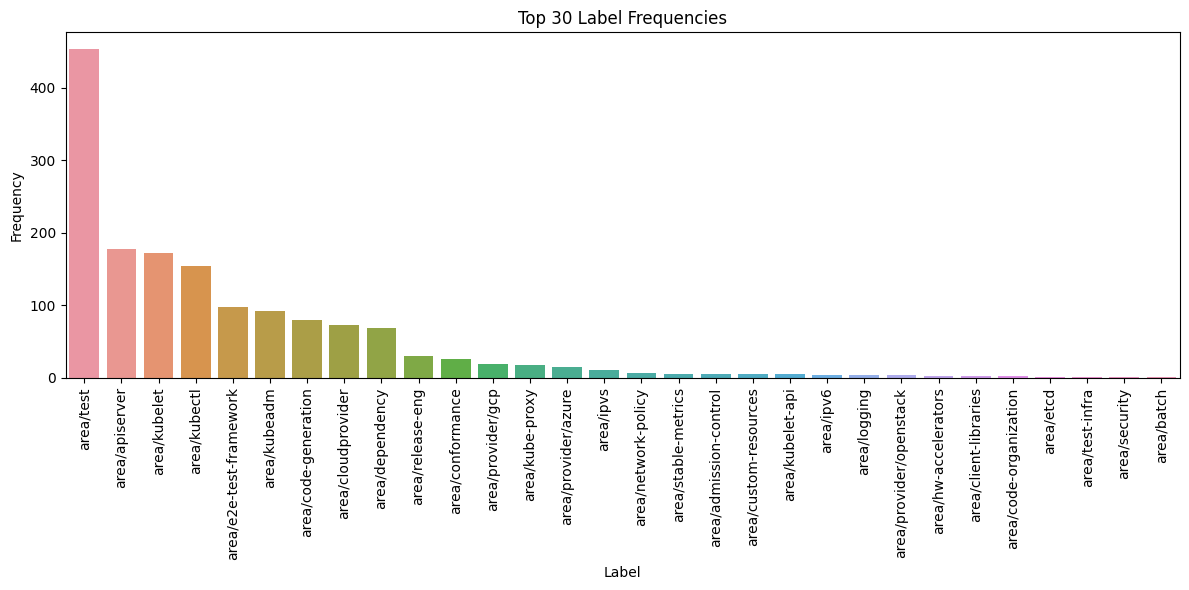

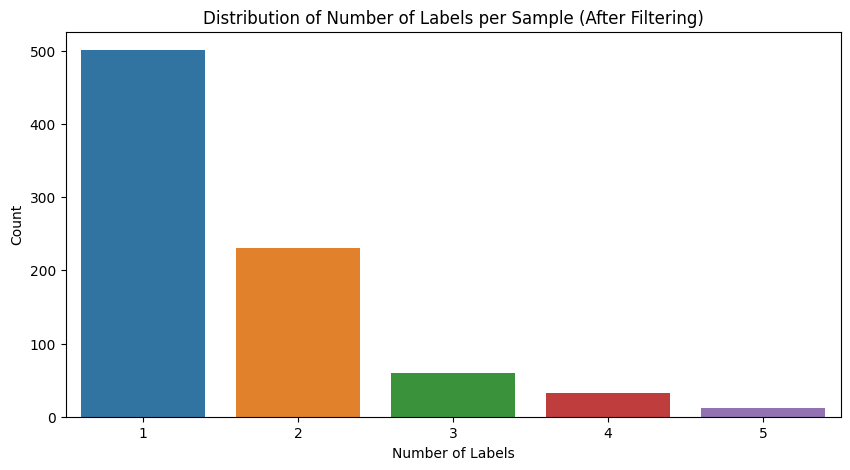

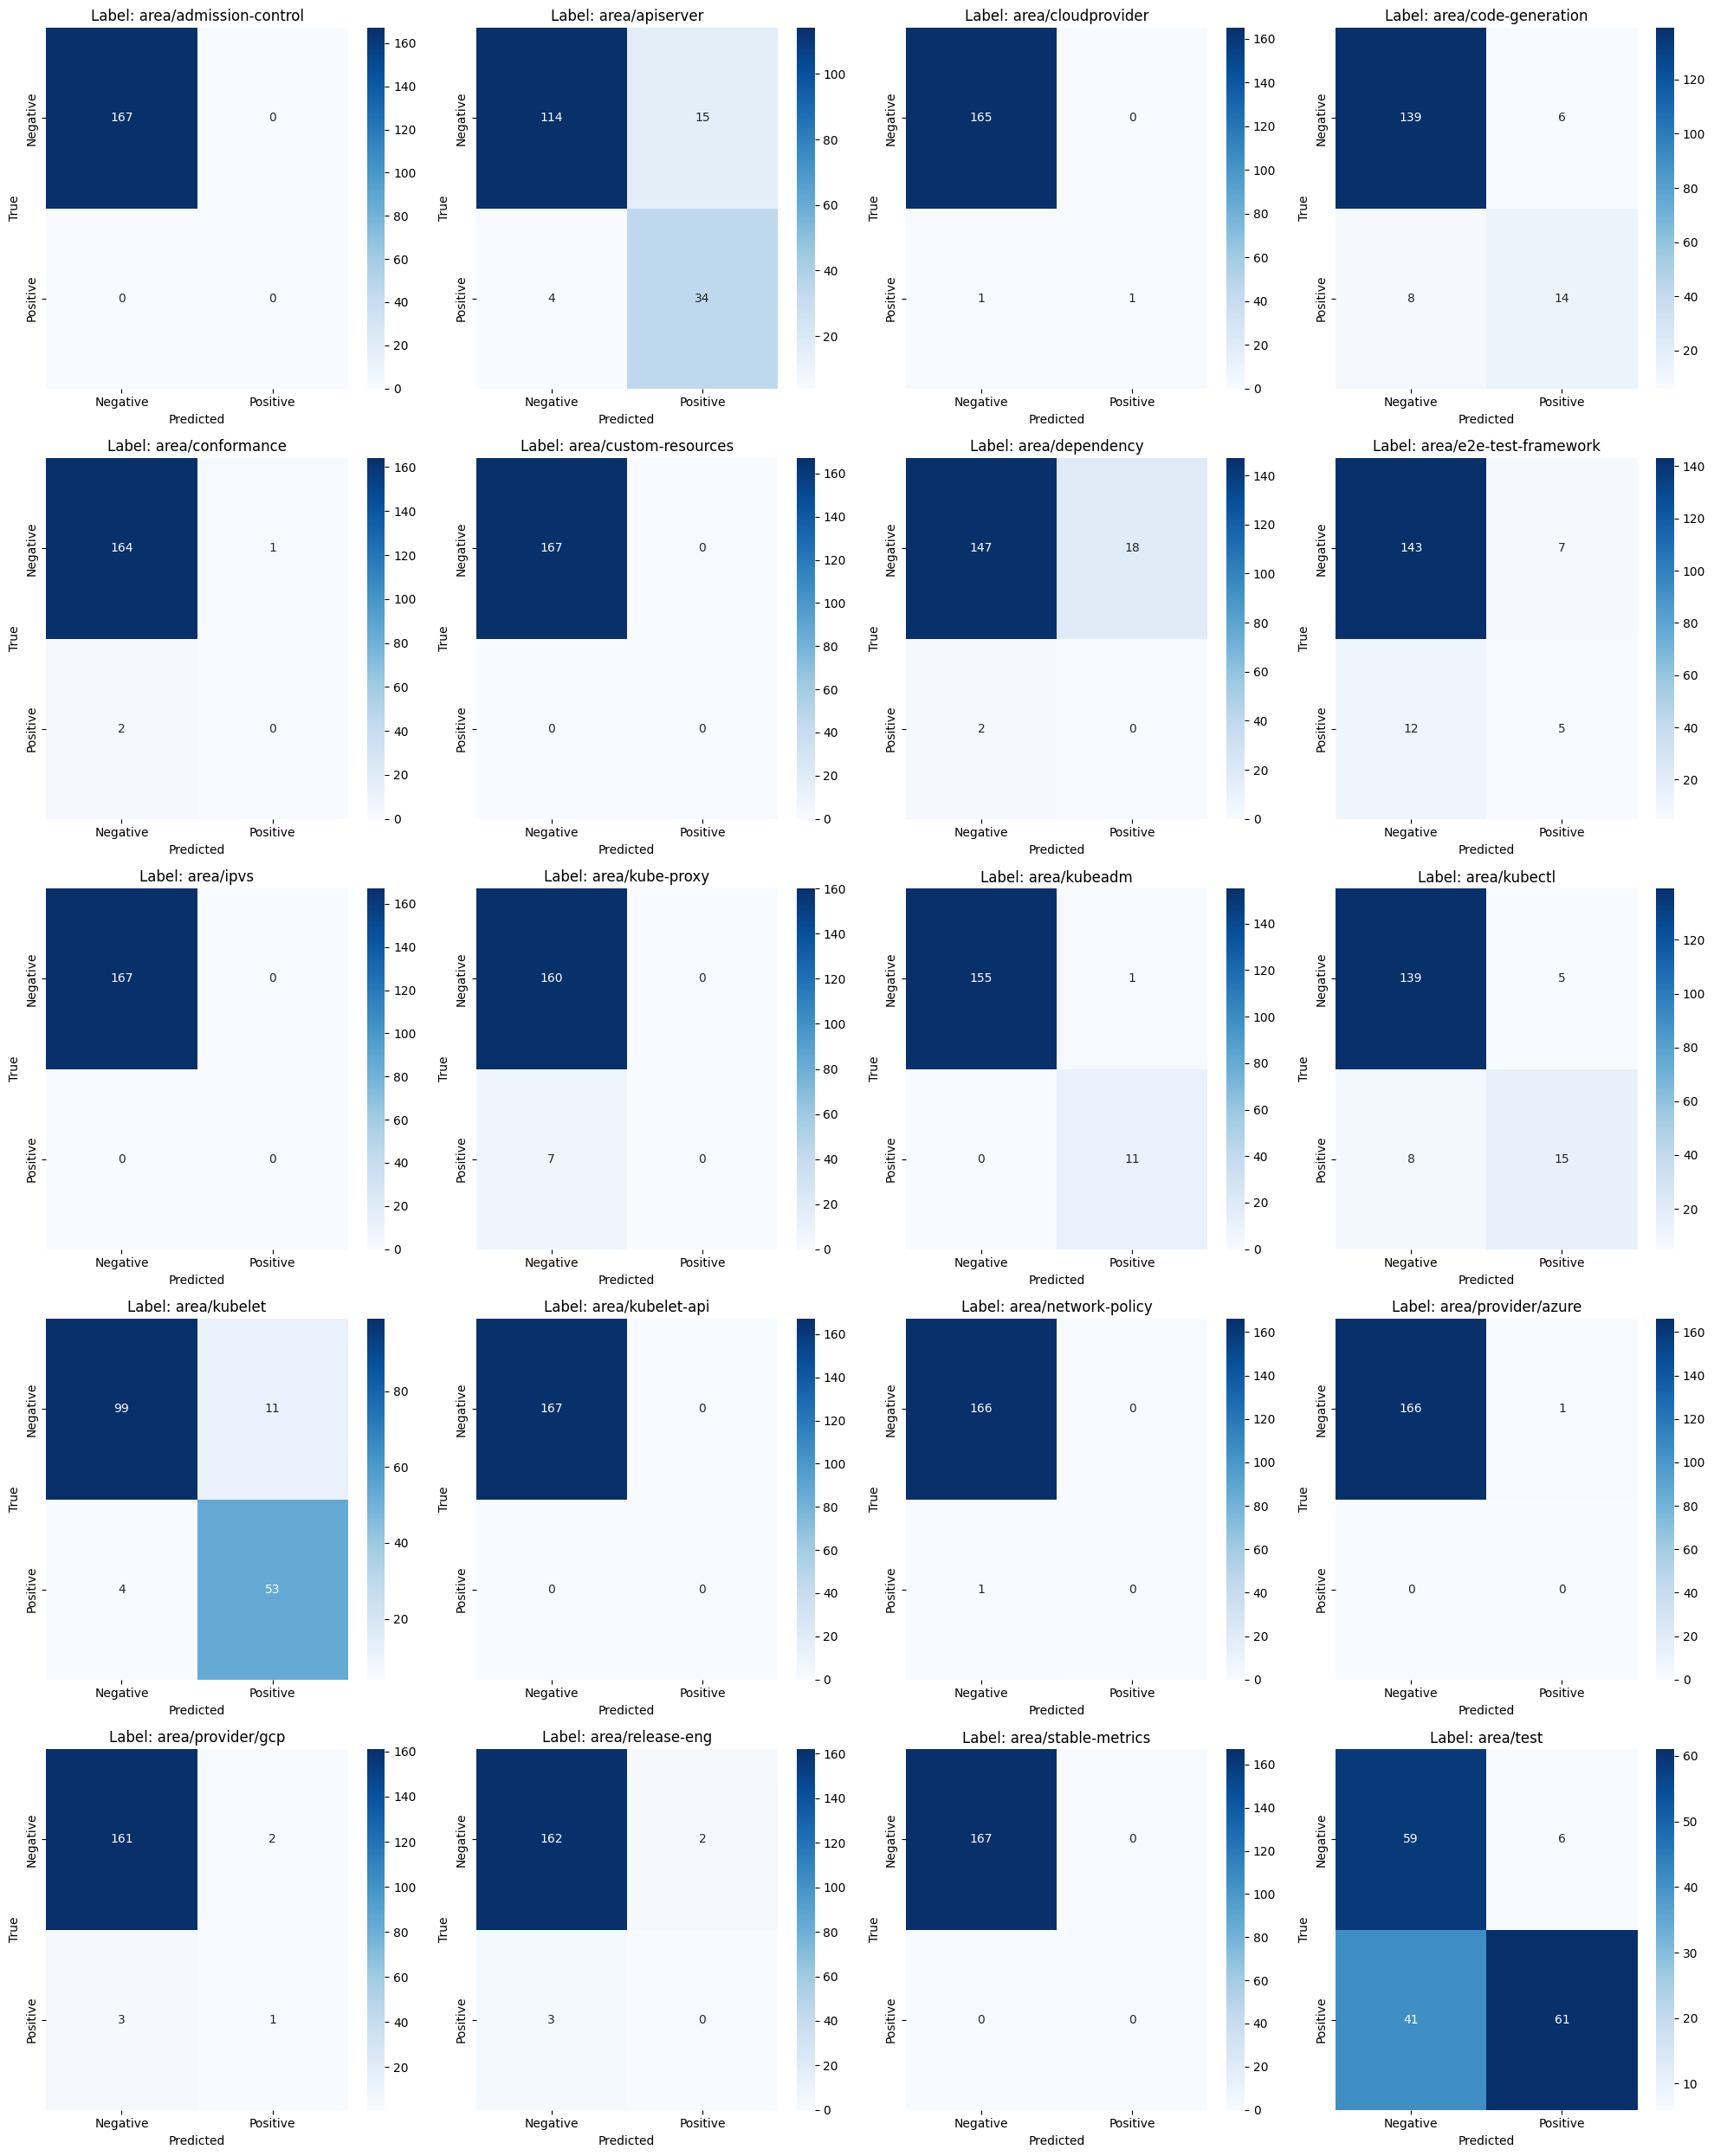

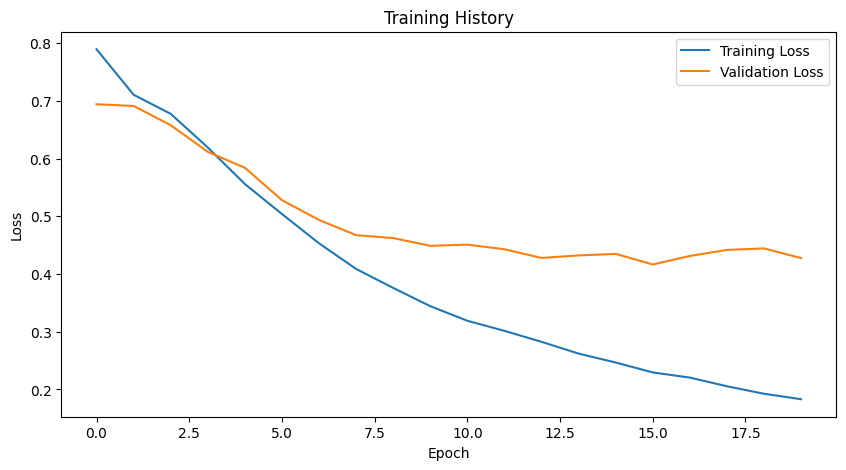

In [ ]:
def main():
    """
    Main function to run the multi-label classification pipeline with CodeBERT.
    This function loads data, preprocesses it, trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load data
    print("Loading data...")
    data_path = "/kaggle/input/kubernetes-cleaned-data-with-changed-file-info/cleaned_data_with_changed_files.json"
    df = pd.read_json(data_path)

    # Filter out rows with empty text
    df = df[['all_text','labels']]
    df = df[df.all_text != "nan"]
    df = df[df.labels != "nan"]
    df = df.dropna()
    
    # Extract issue texts and labels
    texts = df['all_text']  
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists

    # Calculate label frequency
    all_labels = []
    for label_list in labels:
        all_labels.extend(label_list)
    
    label_freq = pd.Series(all_labels).value_counts()
    print("\nTotal number of unique labels:", len(label_freq))
    
    # Filter out infrequent labels (less than 5 occurrences)
    min_label_freq = 5
    frequent_labels = label_freq[label_freq >= min_label_freq].index.tolist()
    print(f"Number of labels with at least {min_label_freq} occurrences: {len(frequent_labels)}")
    
    # Keep only the frequent labels in each sample
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    
    # Now filter to keep only samples with 1-5 labels
    max_label_count = 5
    label_length = filtered_labels.apply(len)
    mask = (label_length > 0) & (label_length <= max_label_count)
    
    texts = texts[mask].reset_index(drop=True)
    filtered_labels = filtered_labels[mask].reset_index(drop=True)
    
    # Add visualization of label frequency before filtering
    plt.figure(figsize=(12, 6))
    top_30_labels = label_freq.nlargest(30)
    sns.barplot(x=top_30_labels.index, y=top_30_labels.values)
    plt.title('Top 30 Label Frequencies')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('label_frequency_distribution.png')
    print("Label frequency distribution saved as 'label_frequency_distribution.png'")
    
    # Visualize label length distribution after filtering
    plt.figure(figsize=(10, 5))
    filtered_label_length = filtered_labels.apply(len)
    sns.countplot(x=filtered_label_length)
    plt.title('Distribution of Number of Labels per Sample (After Filtering)')
    plt.xlabel('Number of Labels')
    plt.ylabel('Count')
    plt.savefig('filtered_label_length_distribution.png')
    print("Filtered label length distribution saved as 'filtered_label_length_distribution.png'")
    
    print("\nLabel length distribution after filtering:")
    label_length_counts = filtered_label_length.value_counts().sort_index()
    for length, count in label_length_counts.items():
        print(f"  {length} labels: {count} samples ({count/len(filtered_labels)*100:.2f}%)")
    
    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Print label statistics
    unique_labels = len(mlb.classes_)
    print(f"Number of unique labels after filtering: {unique_labels}")
    print(f"Example of encoded labels shape: {labels_encoded.shape}")
    
    # Calculate and print label distribution
    label_counts = labels_encoded.sum(axis=0)
    print("Label distribution (top 10):")
    for i, label in enumerate(mlb.classes_[:10]):
        print(f"  {label}: {label_counts[i]} occurrences")
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (labels_encoded.shape[0] * labels_encoded.shape[1])
    print(f"Label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / labels_encoded.shape[0]:.2f}")
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = 16
    train_dataset = IssueDataset(train_texts, train_labels, tokenizer)
    val_dataset = IssueDataset(val_texts, val_labels, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    model = CodeBERTClassifier(num_labels=unique_labels).to(device)
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=3, min_delta=0.01)
    
    # Training loop
    num_epochs = 20
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Hamming): {accuracy_metrics['hamming']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_codebert_multilabel_model.pt')
            print("Saved new best model")
        
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    model.load_state_dict(torch.load('best_codebert_multilabel_model.pt'))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Hamming Accuracy: {final_acc_metrics['hamming']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    fig.savefig('multilabel_confusion_matrices.png')
    print("Confusion matrices saved as 'multilabel_confusion_matrices.png'")
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.savefig('training_history.png')
    print("Training history saved as 'training_history.png'")
    
    print("\nTraining completed!")
    
    return {
        'metrics': {
            'exact_match': final_acc_metrics['exact_match'],
            'hamming': final_acc_metrics['hamming'],
            'jaccard': final_acc_metrics['jaccard'],
            'precision': final_precision,
            'recall': final_recall, 
            'f1': final_f1,
        },
        'model': model,
        'label_encoder': mlb
    }

if __name__ == "__main__":
    results = main()

# Keep data that have <= 5 labels & min 5 data per label & min combination of 2 data

Using device: cuda
Number of labels with at least 0 occurrences: 31
Removed 0 infrequent labels
Number of samples after filtering: 865
Number of label combinations with at least 4 occurrences: 31
Removed 97 infrequent label combinations
Number of samples with frequent label combinations: 726
Final number of samples after all filtering: 726

 Label Distribution : 
0. area/test: 380
1. area/apiserver: 123
2. area/kubelet: 120
3. area/kubectl: 105
4. area/e2e-test-framework: 75
5. area/kubeadm: 71
6. area/code-generation: 50
7. area/cloudprovider: 38
8. area/dependency: 28
9. area/conformance: 15
10. area/provider/azure: 11
11. area/provider/gcp: 6
12. area/release-eng: 6
13. area/kube-proxy: 6
14. area/ipv6: 4
15. area/ipvs: 4

 Label count per row distribution:
Label: 1, count: 492
Label: 2, count: 184
Label: 3, count: 28
Label: 4, count: 17
Label: 6, count: 5

 Label combinations distribution:
0. Label combination: ('area/test',), count: 161
1. Label combination: ('area/kubectl',), cou

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

Computing class weights for imbalanced labels...
Initializing model...


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Using weighted BCE loss
Starting training for 20 epochs...

Epoch 1/20


Training: 100%|██████████| 37/37 [00:27<00:00,  1.33it/s]


Train Loss: 0.8366, Train Accuracy (Exact Match): 0.0069
Val Loss: 0.7902
Val Accuracy (Exact Match): 0.0548
Val Accuracy (Hamming): 0.8365
Val Accuracy (Jaccard): 0.1015
Val Precision: 0.1518, Val Recall: 0.1250, Val F1: 0.1240
Saved new best model

Epoch 2/20


Training: 100%|██████████| 37/37 [00:28<00:00,  1.30it/s]


Train Loss: 0.7479, Train Accuracy (Exact Match): 0.0328
Val Loss: 0.7663
Val Accuracy (Exact Match): 0.0000
Val Accuracy (Hamming): 0.7945
Val Accuracy (Jaccard): 0.1390
Val Precision: 0.1678, Val Recall: 0.3037, Val F1: 0.2035
Saved new best model

Epoch 3/20


Training: 100%|██████████| 37/37 [00:30<00:00,  1.21it/s]


Train Loss: 0.7044, Train Accuracy (Exact Match): 0.0483
Val Loss: 0.7426
Val Accuracy (Exact Match): 0.0959
Val Accuracy (Hamming): 0.8694
Val Accuracy (Jaccard): 0.2727
Val Precision: 0.3219, Val Recall: 0.4224, Val F1: 0.3433
Saved new best model

Epoch 4/20


Training: 100%|██████████| 37/37 [00:33<00:00,  1.11it/s]


Train Loss: 0.6261, Train Accuracy (Exact Match): 0.1224
Val Loss: 0.6442
Val Accuracy (Exact Match): 0.1438
Val Accuracy (Hamming): 0.8904
Val Accuracy (Jaccard): 0.4344
Val Precision: 0.5240, Val Recall: 0.6792, Val F1: 0.5458
Saved new best model

Epoch 5/20


Training: 100%|██████████| 37/37 [00:31<00:00,  1.16it/s]


Train Loss: 0.5262, Train Accuracy (Exact Match): 0.2310
Val Loss: 0.6051
Val Accuracy (Exact Match): 0.2192
Val Accuracy (Hamming): 0.9033
Val Accuracy (Jaccard): 0.4909
Val Precision: 0.5965, Val Recall: 0.6992, Val F1: 0.5933
Saved new best model

Epoch 6/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.13it/s]


Train Loss: 0.4512, Train Accuracy (Exact Match): 0.3603
Val Loss: 0.5463
Val Accuracy (Exact Match): 0.3904
Val Accuracy (Hamming): 0.9332
Val Accuracy (Jaccard): 0.6340
Val Precision: 0.7608, Val Recall: 0.7700, Val F1: 0.7182
Saved new best model

Epoch 7/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.15it/s]


Train Loss: 0.3951, Train Accuracy (Exact Match): 0.5241
Val Loss: 0.5283
Val Accuracy (Exact Match): 0.4521
Val Accuracy (Hamming): 0.9469
Val Accuracy (Jaccard): 0.6661
Val Precision: 0.8151, Val Recall: 0.7317, Val F1: 0.7365
Saved new best model

Epoch 8/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.15it/s]


Train Loss: 0.3526, Train Accuracy (Exact Match): 0.5759
Val Loss: 0.5103
Val Accuracy (Exact Match): 0.4384
Val Accuracy (Hamming): 0.9414
Val Accuracy (Jaccard): 0.6567
Val Precision: 0.7938, Val Recall: 0.7460, Val F1: 0.7326

Epoch 9/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.14it/s]


Train Loss: 0.3222, Train Accuracy (Exact Match): 0.6017
Val Loss: 0.5061
Val Accuracy (Exact Match): 0.4521
Val Accuracy (Hamming): 0.9426
Val Accuracy (Jaccard): 0.6659
Val Precision: 0.8053, Val Recall: 0.7426, Val F1: 0.7392
Saved new best model

Epoch 10/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.15it/s]


Train Loss: 0.2901, Train Accuracy (Exact Match): 0.6207
Val Loss: 0.5130
Val Accuracy (Exact Match): 0.4178
Val Accuracy (Hamming): 0.9358
Val Accuracy (Jaccard): 0.6418
Val Precision: 0.7760, Val Recall: 0.7374, Val F1: 0.7180

Epoch 11/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.15it/s]


Train Loss: 0.2642, Train Accuracy (Exact Match): 0.6224
Val Loss: 0.4793
Val Accuracy (Exact Match): 0.4521
Val Accuracy (Hamming): 0.9392
Val Accuracy (Jaccard): 0.6671
Val Precision: 0.7831, Val Recall: 0.7723, Val F1: 0.7403
Saved new best model

Epoch 12/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.14it/s]


Train Loss: 0.2372, Train Accuracy (Exact Match): 0.6362
Val Loss: 0.5056
Val Accuracy (Exact Match): 0.5000
Val Accuracy (Hamming): 0.9482
Val Accuracy (Jaccard): 0.6924
Val Precision: 0.8311, Val Recall: 0.7432, Val F1: 0.7546
Saved new best model

Epoch 13/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.14it/s]


Train Loss: 0.2224, Train Accuracy (Exact Match): 0.6845
Val Loss: 0.4956
Val Accuracy (Exact Match): 0.5000
Val Accuracy (Hamming): 0.9418
Val Accuracy (Jaccard): 0.6854
Val Precision: 0.8019, Val Recall: 0.7637, Val F1: 0.7496

Epoch 14/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.14it/s]


Train Loss: 0.2080, Train Accuracy (Exact Match): 0.6897
Val Loss: 0.4966
Val Accuracy (Exact Match): 0.4589
Val Accuracy (Hamming): 0.9405
Val Accuracy (Jaccard): 0.6733
Val Precision: 0.8041, Val Recall: 0.7620, Val F1: 0.7453

Epoch 15/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.15it/s]


Train Loss: 0.1934, Train Accuracy (Exact Match): 0.6983
Val Loss: 0.4887
Val Accuracy (Exact Match): 0.5205
Val Accuracy (Hamming): 0.9499
Val Accuracy (Jaccard): 0.7118
Val Precision: 0.8236, Val Recall: 0.7797, Val F1: 0.7715
Saved new best model

Epoch 16/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.15it/s]


Train Loss: 0.1810, Train Accuracy (Exact Match): 0.7276
Val Loss: 0.5078
Val Accuracy (Exact Match): 0.5274
Val Accuracy (Hamming): 0.9499
Val Accuracy (Jaccard): 0.7029
Val Precision: 0.8236, Val Recall: 0.7568, Val F1: 0.7594

Epoch 17/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.14it/s]


Train Loss: 0.1649, Train Accuracy (Exact Match): 0.7310
Val Loss: 0.5259
Val Accuracy (Exact Match): 0.5137
Val Accuracy (Hamming): 0.9473
Val Accuracy (Jaccard): 0.6823
Val Precision: 0.8031, Val Recall: 0.7295, Val F1: 0.7365

Epoch 18/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.14it/s]


Train Loss: 0.1547, Train Accuracy (Exact Match): 0.7500
Val Loss: 0.5312
Val Accuracy (Exact Match): 0.4795
Val Accuracy (Hamming): 0.9461
Val Accuracy (Jaccard): 0.6689
Val Precision: 0.8071, Val Recall: 0.7192, Val F1: 0.7301

Epoch 19/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.14it/s]


Train Loss: 0.1498, Train Accuracy (Exact Match): 0.7414
Val Loss: 0.5540
Val Accuracy (Exact Match): 0.4795
Val Accuracy (Hamming): 0.9414
Val Accuracy (Jaccard): 0.6672
Val Precision: 0.8042, Val Recall: 0.7203, Val F1: 0.7283

Epoch 20/20


Training: 100%|██████████| 37/37 [00:32<00:00,  1.14it/s]


Train Loss: 0.1437, Train Accuracy (Exact Match): 0.7293
Val Loss: 0.5187
Val Accuracy (Exact Match): 0.5205
Val Accuracy (Hamming): 0.9495
Val Accuracy (Jaccard): 0.7126
Val Precision: 0.8219, Val Recall: 0.7820, Val F1: 0.7721
Saved new best model

Loading best model for final evaluation...


<ipython-input-10-74a9fafe359c>:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_codebert_multilabel_model.pt'))



Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.5205
Hamming Accuracy: 0.9495
Jaccard Similarity: 0.7126
Precision: 0.8219
Recall: 0.7820
F1 Score: 0.7721


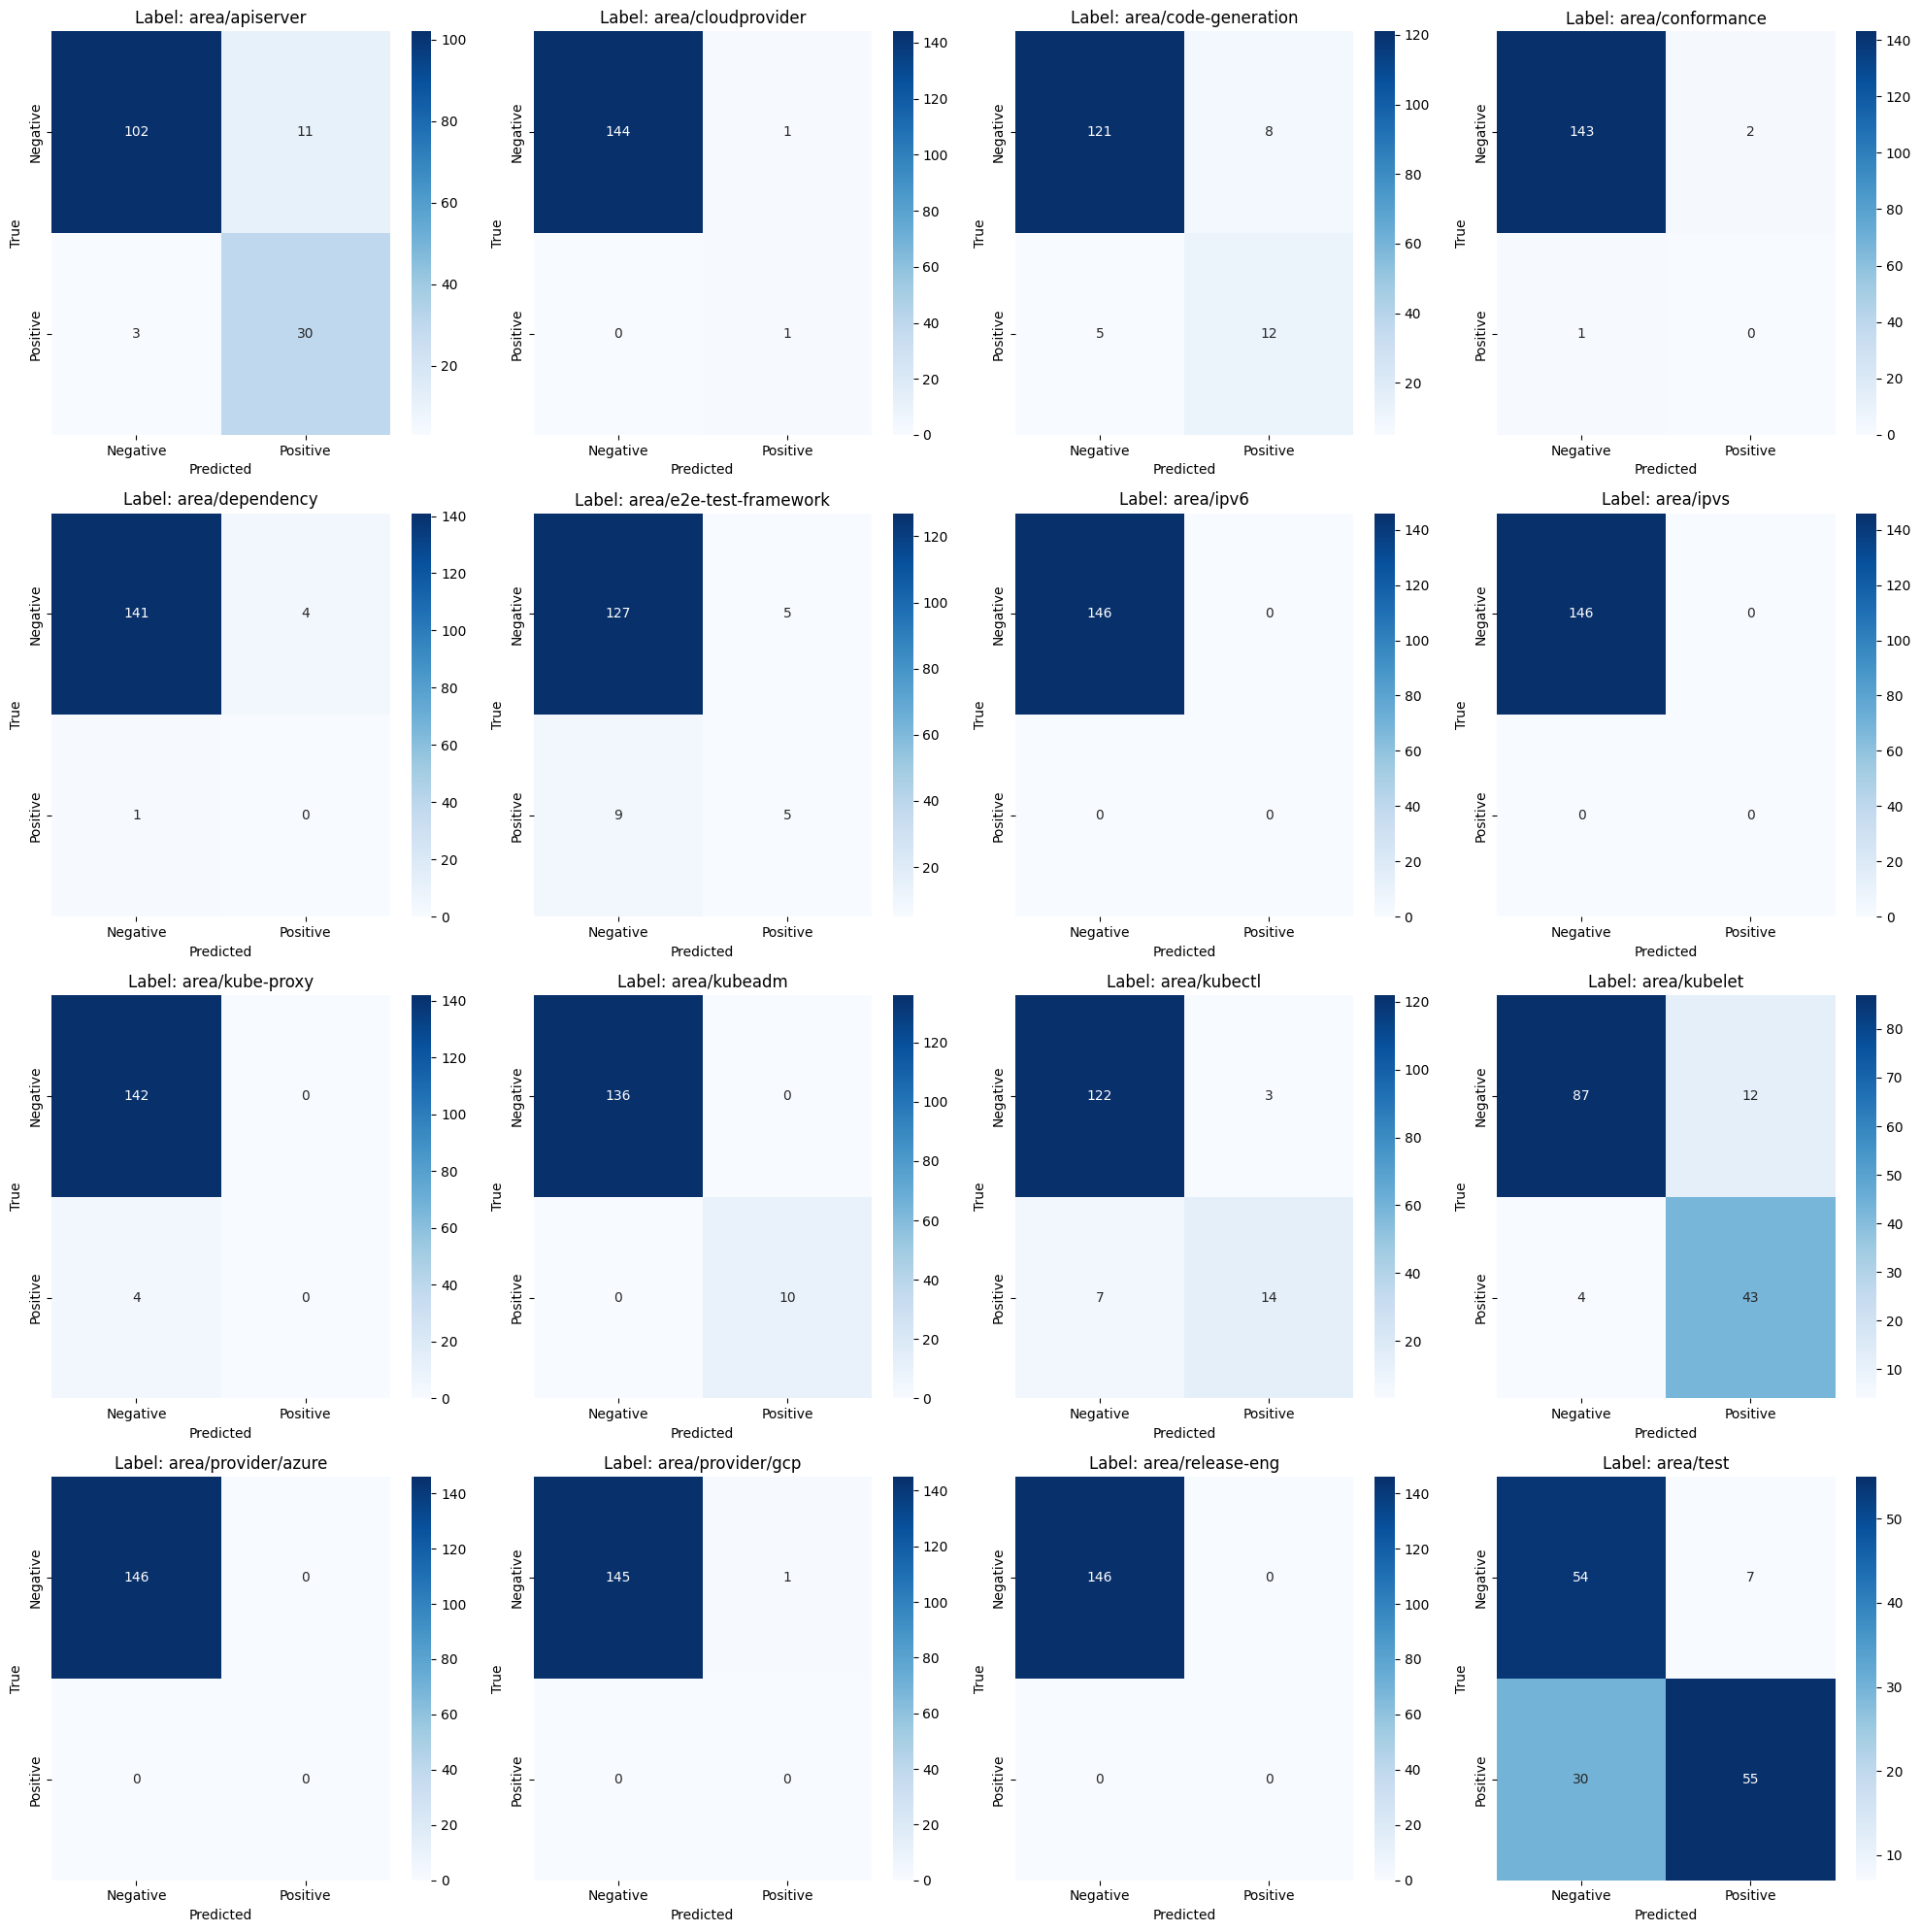

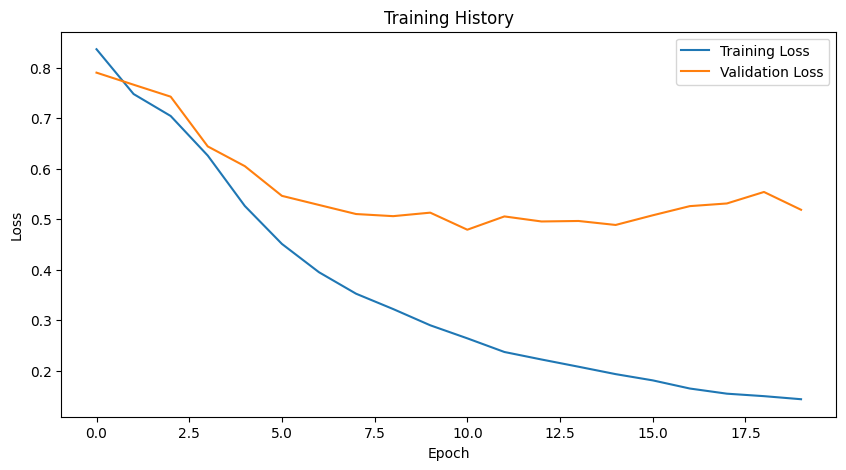


Training completed!


In [ ]:
def main():
    """
    Main function to run the multi-label classification pipeline with CodeBERT.
    This function loads data, preprocesses it, trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load data
    data_path = "/kaggle/input/kubernetes-cleaned-data-with-changed-file-info/cleaned_data_with_changed_files.json"
    df = pd.read_json(data_path)
    
    # Use prepare_data function to filter and prepare data
    texts, filtered_labels = prepare_data(df, min_label_freq=5, max_label_len=5, min_label_comb_freq=2)
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\n Label Distribution : ')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\n Label count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')

    # Count the distribution of label combinations
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    print('\n Label combinations distribution:')
    for i, (labels, count) in enumerate(sorted(label_combinations.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. Label combination: {labels}, count: {count}')
    
    # Encode multi-labels using MultiLabelBinarizer
    print("\n Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Calculate  label distribution
    label_counts = labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (labels_encoded.shape[0] * labels_encoded.shape[1])
    print(f"Label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / labels_encoded.shape[0]:.2f}")
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Initialize tokenizer
    print("Loading tokenizer...")
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = 16
    train_dataset = IssueDataset(train_texts, train_labels, tokenizer)
    val_dataset = IssueDataset(val_texts, val_labels, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    model = CodeBERTClassifier(num_labels=len(mlb.classes_)).to(device)
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=3, min_delta=0.01)
    
    # Training loop
    num_epochs = 20
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Validate
        val_loss, accuracy_metrics, val_precision, val_recall, val_f1 = validate(
            model, val_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Val Accuracy (Hamming): {accuracy_metrics['hamming']:.4f}")
        print(f"Val Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        
        # Save best model based on F1 score
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_codebert_multilabel_model.pt')
            print("Saved new best model")
        
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    model.load_state_dict(torch.load('best_codebert_multilabel_model.pt'))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, val_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Hamming Accuracy: {final_acc_metrics['hamming']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_val_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_val_labels = np.vstack(all_val_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_val_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()
    
    print("\nTraining completed!")
    
    return {
        'metrics': {
            'exact_match': final_acc_metrics['exact_match'],
            'hamming': final_acc_metrics['hamming'],
            'jaccard': final_acc_metrics['jaccard'],
            'precision': final_precision,
            'recall': final_recall, 
            'f1': final_f1,
        },
        'model': model,
        'label_encoder': mlb
    }
    
if __name__ == "__main__":
    results = main()